# Issue 5 - descriptive statistics

## Question 1: Which teams have most consistently had the highest scores?

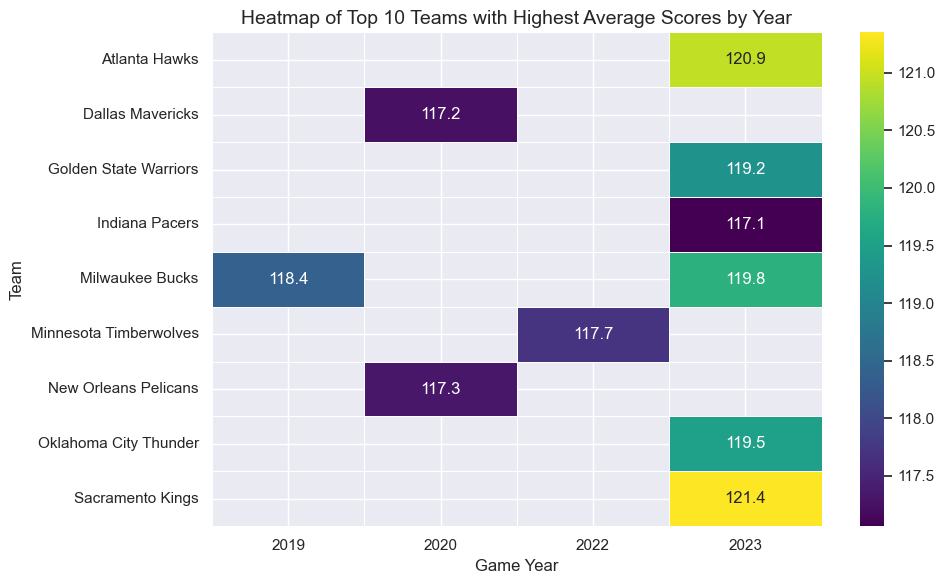

In [45]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home', 'game_year'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away', 'game_year'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name', 'game_year']
score_stats_away.index.names = ['team_id', 'team_name', 'game_year']

combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name','game_year']).mean()
score_stats_all['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats_all = score_stats_all[score_stats_all['total_games'] >= 100]

top_teams = score_stats_all.sort_values(by='mean', ascending=False).head(10)

top_teams_reset = top_teams.reset_index()

heatmap_data = top_teams_reset.pivot(index='team_name', columns='game_year', values='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".1f", linewidths=.5)

# Add labels and title
plt.title('Heatmap of Top 10 Teams with Highest Average Scores by Year', fontsize=14)
plt.xlabel('Game Year', fontsize=12)
plt.ylabel('Team', fontsize=12)
plt.tight_layout()
plt.show()

## Question 2 - Which team has had below average for the most consecutive seasons?


                        Team_Name     Team_ID  Seasons_Below_Average
0                 New York Knicks  1610612752                     74
1                  Boston Celtics  1610612738                     70
2                   Chicago Bulls  1610612741                     61
3                 Detroit Pistons  1610612765                     59
4                   Atlanta Hawks  1610612737                     58
..                            ...         ...                    ...
78        Roma Virtus Lottomatica       12307                      1
79                Toronto Huskies  1610610035                      1
80  Unicaja Malaga Unicaja Malaga       12311                      1
81                 Waterloo Hawks  1610610037                      1
82        West NBA All Stars West  1610616834                      1

[83 rows x 3 columns]


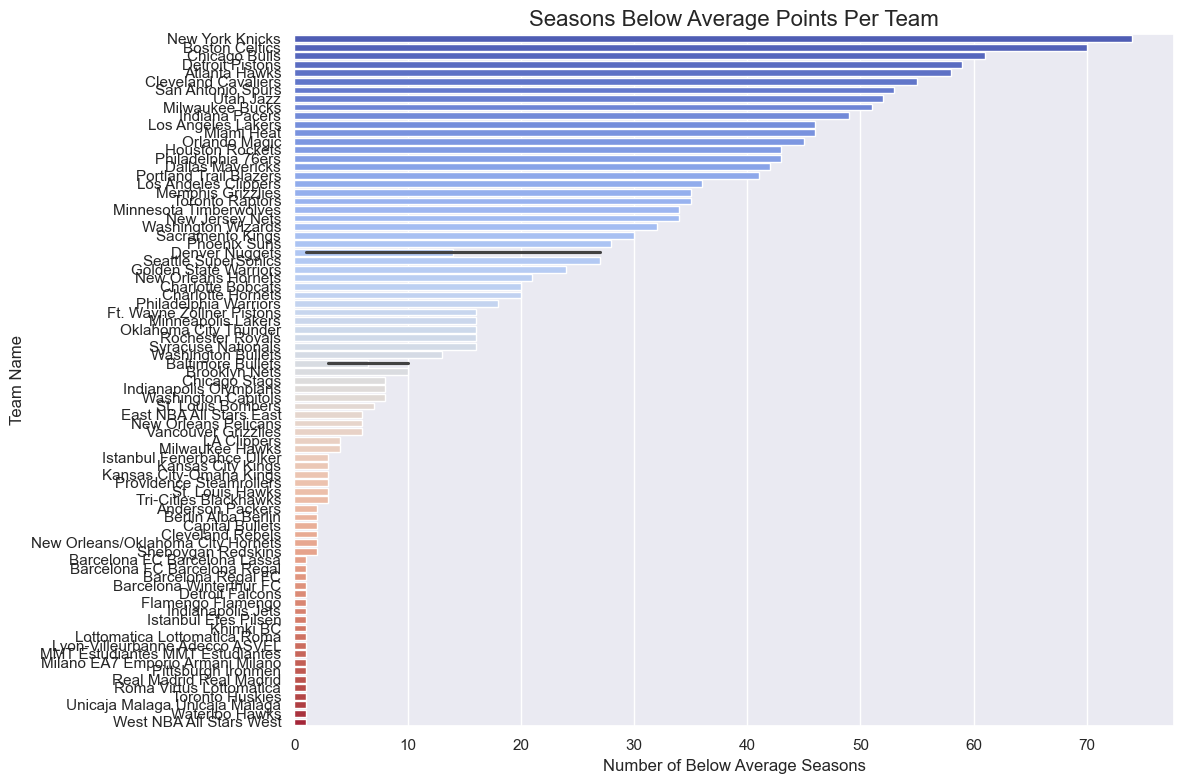

In [50]:
# Calculate the overall average points
total_avg_points = pd.read_sql_query(
    "SELECT AVG(pts_home + pts_away) AS Average_Points FROM game", con
).iloc[0, 0]  # Retrieves the calculated average

# Query teams with below-average points for consecutive seasons
query = f"""
SELECT 
    team_name_home AS Team_Name,
    team_id_home AS Team_ID,
    COUNT(season_id) AS Seasons_Below_Average
FROM (
    SELECT 
        season_id,
        team_id_home,
        team_name_home,
        AVG(pts_home + pts_away) AS Season_Avg_Points
    FROM game
    GROUP BY season_id, team_id_home
    HAVING AVG(pts_home + pts_away) < {total_avg_points}
)
GROUP BY team_name_home, team_id_home
ORDER BY Seasons_Below_Average DESC
"""

# Execute and display results
below_average = pd.read_sql_query(query, con)
print(below_average)


## Question 3 - Which team has consistently made it to the playoffs?


In [48]:
# Calculate the overall average points
total_avg_points = pd.read_sql_query(
    "SELECT AVG(pts_home + pts_away) AS Average_Points FROM game", con
).iloc[0, 0]  # Retrieves the calculated average

# Query teams with below-average points for consecutive seasons
query = f"""
SELECT 
    team_name_home AS Team_Name,
    team_id_home AS Team_ID,
    COUNT(season_id) AS Seasons_In_Playoff
FROM (
    SELECT 
        season_id,
        team_id_home,
        team_name_home
    FROM game WHERE season_type = 'Playoffs'
    GROUP BY season_id, team_id_home
)
GROUP BY team_name_home, team_id_home
ORDER BY Seasons_In_Playoff DESC
"""

# Execute and display results
below_average = pd.read_sql_query(query, con)
print(below_average)



plt.figure(figsize=(12, 8))
sns.barplot(
    data=below_average.sort_values(by="Seasons_In_Playoff", ascending=False), x="Seasons_In_Playoff", y="Team_Name", hue="Team_Name", dodge=False, palette="viridis", legend=False)

# Add labels and title
plt.title("Playoff Appearances Per Team", fontsize=16)
plt.xlabel("Number of Playoff Appearances", fontsize=12)
plt.ylabel("Team Name", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()



                    Team_Name     Team_ID  Seasons_In_Playoff
0              Boston Celtics  1610612738                  54
1          Los Angeles Lakers  1610612747                  45
2             New York Knicks  1610612752                  38
3          Philadelphia 76ers  1610612755                  35
4           San Antonio Spurs  1610612759                  34
5               Atlanta Hawks  1610612737                  33
6               Chicago Bulls  1610612741                  33
7             Milwaukee Bucks  1610612749                  33
8      Portland Trail Blazers  1610612757                  33
9             Houston Rockets  1610612745                  31
10               Phoenix Suns  1610612756                  28
11             Denver Nuggets  1610612743                  27
12            Detroit Pistons  1610612765                  27
13                  Utah Jazz  1610612762                  27
14           Dallas Mavericks  1610612742                  22
15      

## Question 4 - Which teams have shown the greatest improvement over the past five years?


In [55]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home', 'game_year'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away', 'game_year'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name', 'game_year']
score_stats_away.index.names = ['team_id', 'team_name', 'game_year']


combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name','game_year']).mean()

score_stats_all = score_stats_all.sort_values(by=['team_name', 'game_year'], ascending=[True, True])

score_stats_all['Difference'] = score_stats_all.groupby('team_name')['mean'].diff()


# teams with highest average
print("Teams highest year over year improvement over past 5 years: ")
print(score_stats_all.sort_values(by='Difference', ascending=False).head(10)) 

season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()





Teams highest year over year improvement over past 5 years: 
                                                   mean        std  count  \
team_id    team_name              game_year                                 
1610612760 Oklahoma City Thunder  2023       119.475379  11.428609   23.0   
                                  2022       110.795960  13.150085   44.5   
1610612763 Memphis Grizzlies      2020       114.344545  10.651583   23.5   
1610612766 Charlotte Hornets      2021       110.602733  12.377413   54.0   
1610612758 Sacramento Kings       2023       121.351190  14.097170   27.5   
1610612737 Atlanta Hawks          2023       120.935556  10.581633   26.0   
1610612750 Minnesota Timberwolves 2022       117.711762  12.590458   47.5   
1610612746 LA Clippers            2023       116.750000  15.681210   24.5   
1610612744 Golden State Warriors  2023       119.241379  12.043391   29.0   
1610612742 Dallas Mavericks       2020       117.234127  10.458553   27.5   

              

## Question 5 - Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?


In [19]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

games_recent_5yrs['win_home'] = games_recent_5yrs['wl_home'].map({'W': 1, 'L': 0})
games_recent_5yrs['win_away'] = games_recent_5yrs['wl_away'].map({'W': 1, 'L': 0})

# Prepare home stats
home_stats = games_recent_5yrs.groupby(['team_id_home', 'team_name_home', 'game_year'])[['blk_home', 'stl_home', 'win_home']].sum().reset_index()
home_stats.columns = ['team_id', 'team_name', 'game_year', 'total_blocks', 'total_steals', 'total_wins']

# Prepare away stats
away_stats = games_recent_5yrs.groupby(['team_id_away', 'team_name_away', 'game_year'])[['blk_away', 'stl_away', 'win_away']].sum().reset_index()
away_stats.columns = ['team_id', 'team_name', 'game_year', 'total_blocks', 'total_steals', 'total_wins']

# Combine home and away stats
all_stats = pd.concat([home_stats, away_stats])

# Group by team and year to sum up home and away stats
final_stats = all_stats.groupby(['team_id', 'team_name', 'game_year']).sum().reset_index()
final_stats.set_index(['team_id', 'team_name', 'game_year'], inplace=True)

print("Teams defensive metrics: ")
print(final_stats.sort_values(by='total_wins', ascending=False).head(10)) 


Teams defensive metrics: 
                                            total_blocks  total_steals  \
team_id    team_name             game_year                               
1610612756 Phoenix Suns          2021              538.0         973.0   
1610612749 Milwaukee Bucks       2021              594.0        1041.0   
1610612762 Utah Jazz             2021              609.0         794.0   
1610612751 Brooklyn Nets         2021              611.0         787.0   
1610612738 Boston Celtics        2022              628.0         731.0   
1610612749 Milwaukee Bucks       2019              589.0         744.0   
1610612755 Philadelphia 76ers    2021              718.0        1044.0   
1610612746 LA Clippers           2021              540.0         906.0   
1610612761 Toronto Raptors       2019              518.0         853.0   
1610612744 Golden State Warriors 2021              513.0         934.0   

                                            total_wins  
team_id    team_name        

# Issue 6 - Storyboard 

## Question 1: Which teams have most consistently had the highest scores?


### Intro - For our first question, we will be trying to find which team scores the most in their games


In [25]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home'])['pts_home'].agg(['sum', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away'])['pts_away'].agg(['sum', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name']
score_stats_away.index.names = ['team_id', 'team_name']

combined_stats = pd.concat([score_stats_home, score_stats_away])

# teams with highest average
print("Teams with highest total scores:")
print(combined_stats.sort_values(by='sum', ascending=False).head(10)) 

Teams with highest total scores:
                                      sum        std  count
team_id    team_name                                       
1610612749 Milwaukee Bucks        25377.0  12.399917    216
1610612738 Boston Celtics         25220.0  13.193480    221
1610612743 Denver Nuggets         25175.0  12.521091    219
1610612749 Milwaukee Bucks        25154.0  13.052470    218
1610612738 Boston Celtics         24315.0  11.821290    218
1610612743 Denver Nuggets         24313.0  11.027889    219
1610612744 Golden State Warriors  24155.0  12.170417    210
1610612756 Phoenix Suns           23936.0  11.046690    209
1610612748 Miami Heat             23768.0  11.756334    215
1610612746 LA Clippers            23703.0  14.457101    208


### Rising action: We want to see how consistent teams are by season

In [32]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby('team_name_home')['pts_home'].mean()
score_stats_away = games_recent_5yrs.groupby('team_name_away')['pts_away'].mean()

combined_stats = pd.concat([score_stats_home, score_stats_away]).groupby(level=0).mean()

print("Teams with highest average total scores per game:")
print(combined_stats.sort_values(ascending=False).head(10))

Teams with highest average total scores per game:
Milwaukee Bucks           116.435716
Adelaide 36ers            116.000000
Utah Jazz                 114.124126
Atlanta Hawks             114.082051
Minnesota Timberwolves    114.046378
Sacramento Kings          113.760321
Golden State Warriors     113.553368
Brooklyn Nets             113.466575
New Orleans Pelicans      113.429579
Memphis Grizzlies         113.219401
dtype: float64


### Climax: we want to see how consistent they are by game

### Falling action:  we want to see the standard deviation per season to see how consistent they are. Lower standard deviation will show consistency

### Conclusion: Once we look at the falling action data, we can properly discern the standard deviation that we see fit.


## Question 2 - Which team has had below average for the most consecutive seasons?


### Intro: What is considered average? 

### Rising action: Each season has its own average

### Climax: Teams number of seasons below season average

In [33]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby('team_name_home')['pts_home'].mean()
score_stats_away = games_recent_5yrs.groupby('team_name_away')['pts_away'].mean()

combined_stats = pd.concat([score_stats_home, score_stats_away]).groupby(level=0).mean()

# Calculate league average score per game
league_avg_score = combined_stats.mean()

# Filter teams with below average scores
below_avg_teams = combined_stats[combined_stats < league_avg_score]

print("Teams with below average scores per game:")
print(below_avg_teams)


Teams with below average scores per game:
Charlotte Hornets            109.504817
Chicago Bulls                110.506483
Cleveland Cavaliers          107.244895
Detroit Pistons              106.855801
Miami Heat                   108.997146
New York Knicks              107.797772
Oklahoma City Thunder        110.057584
Orlando Magic                107.049138
Ra'anana Maccabi Ra'anana     87.666667
dtype: float64


### Falling action: the team with the longest streak of being above average

### Conclusion: The team that has the longest streak of being below average

## Question 3 - Which team has consistently made it to the playoffs?

### Introduction: Number of playoff appearances by team

### Rising action: Number of playoff appearances each season by team

### Climax: Teams with the longest streak of making playoffs

### Falling action: Teams that has the longest streak of not making it to playoffs

### Climax: The team that consistently makes it to playoffs (average of seasons played and season playoff)

## Question 4 - Which teams have shown the greatest improvement over the past five years?


### Introduction: Average win percentage by season league total (for now)

### Rising action: average win percentage of team by season 

### Climax: Greatest positive change of win percentage per season by team

### Falling action: Greatest negative change of win percentage per season by team

### Conclusion: Average win percentage change over past 5 years per team 

## Question 5 - Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?


### Introduction:  Average blocks and steals per game by season

### rising action: average blocks and steals per game by team 

### Climax:  Teams with best blocks and steals (show win percentage)

### Falling action: Worst teams when it comes to blocks and steals (show win percentage)

### Conclusion: Teams with highest win percentage has these blocks and steals 

# Issue 7 - Visualizations 

## Question 1: Which teams have most consistently had the highest scores?


### Intro - For our first question, we will be trying to find which team scores the most in their games


### Rising action: We want to see how consistent teams are by season


### Climax: we want to see how consistent they are by game


### Falling action:  we want to see the standard deviation per season to see how consistent they are. Lower standard deviation will show consistency


### Conclusion: Once we look at the falling action data, we can properly discern the standard deviation that we see fit.


## Question 2 - Which team has had below average for the most consecutive seasons?


### Intro: What is considered average? 

Teams with highest average scores:
                                                   mean        std  count  \
team_id    team_name              game_year                                 
1610612758 Sacramento Kings       2023       121.351190  14.097170   27.5   
1610612737 Atlanta Hawks          2023       120.935556  10.581633   26.0   
1610612749 Milwaukee Bucks        2023       119.807692  14.019533   26.0   
1610612760 Oklahoma City Thunder  2023       119.475379  11.428609   23.0   
1610612744 Golden State Warriors  2023       119.241379  12.043391   29.0   
1610612749 Milwaukee Bucks        2019       118.377764  11.766527   48.5   
1610612750 Minnesota Timberwolves 2022       117.711762  12.590458   47.5   
1610612740 New Orleans Pelicans   2020       117.321429  11.167296   22.5   
1610612742 Dallas Mavericks       2020       117.234127  10.458553   27.5   
1610612754 Indiana Pacers         2023       117.063241  12.116996   22.5   

                                        

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29],
 [Text(0, 0, 'Atlanta Hawks'),
  Text(1, 0, 'Boston Celtics'),
  Text(2, 0, 'Cleveland Cavaliers'),
  Text(3, 0, 'New Orleans Pelicans'),
  Text(4, 0, 'Chicago Bulls'),
  Text(5, 0, 'Dallas Mavericks'),
  Text(6, 0, 'Denver Nuggets'),
  Text(7, 0, 'Golden State Warriors'),
  Text(8, 0, 'Houston Rockets'),
  Text(9, 0, 'LA Clippers'),
  Text(10, 0, 'Los Angeles Lakers'),
  Text(11, 0, 'Miami Heat'),
  Text(12, 0, 'Milwaukee Bucks'),
  Text(13, 0, 'Minnesota Timberwolves'),
  Text(14, 0, 'Brooklyn Nets'),
  Text(15, 0, 'New York Knicks'),
  Text(16, 0, 'Orlando Magic'),
  Text(17, 0, 'Indiana Pacers'),
  Text(18, 0, 'Philadelphia 76ers'),
  Text(19, 0, 'Phoenix Suns'),
  Text(20, 0, 'Portland Trail Blazers'),
  Text(21, 0, 'Sacramento Kings'),
  Text(22, 0, 'San Antonio Spurs'),
  Text(23, 0, 'Oklahoma City Thunder'),
 

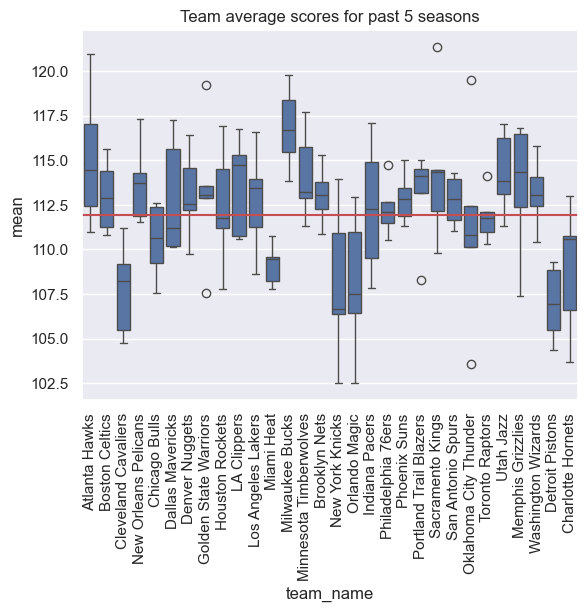

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home', 'game_year'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away', 'game_year'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name', 'game_year']
score_stats_away.index.names = ['team_id', 'team_name', 'game_year']

combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name','game_year']).mean()
score_stats_all['total_games'] = combined_stats.groupby(['team_id', 'team_name'])['count'].sum()
score_stats_all = score_stats_all[score_stats_all['total_games'] >= 100]

# teams with highest average
print("Teams with highest average scores:")
print(score_stats_all.sort_values(by='mean', ascending=False).head(10)) 

season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()

sns.set_theme()
sns.boxplot(data=score_stats_all, x="team_name", y="mean").set_title("Team average scores for past 5 seasons")
plt.axhline(y=season_avg, color='r', linestyle='-', label='Overall Average')
plt.xticks(rotation='vertical')


### Rising action: Each season has its own average

                        Team_Name     Team_ID  Seasons_Below_Average
0                 New York Knicks  1610612752                     74
1                  Boston Celtics  1610612738                     70
2                   Chicago Bulls  1610612741                     61
3                 Detroit Pistons  1610612765                     59
4                   Atlanta Hawks  1610612737                     58
..                            ...         ...                    ...
78        Roma Virtus Lottomatica       12307                      1
79                Toronto Huskies  1610610035                      1
80  Unicaja Malaga Unicaja Malaga       12311                      1
81                 Waterloo Hawks  1610610037                      1
82        West NBA All Stars West  1610616834                      1

[83 rows x 3 columns]


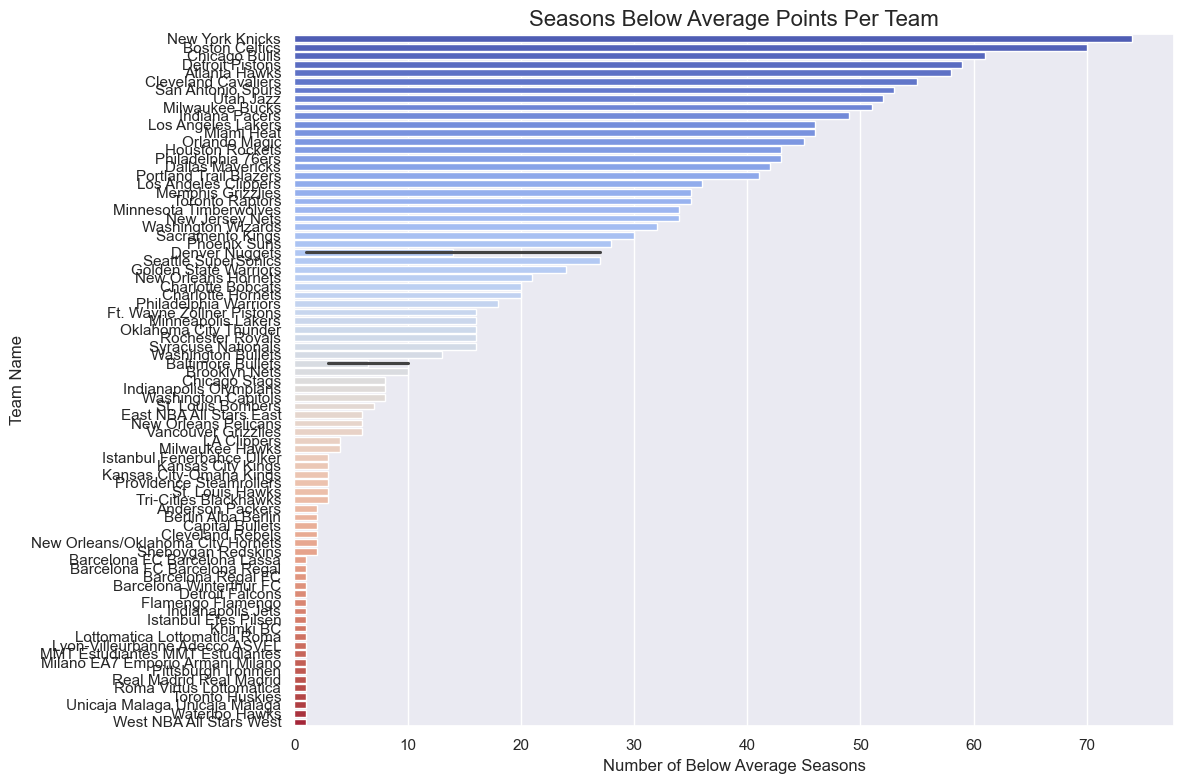

In [52]:
# Calculate the overall average points
total_avg_points = pd.read_sql_query(
    "SELECT AVG(pts_home + pts_away) AS Average_Points FROM game", con
).iloc[0, 0]  # Retrieves the calculated average

# Query teams with below-average points for consecutive seasons
query = f"""
SELECT 
    team_name_home AS Team_Name,
    team_id_home AS Team_ID,
    COUNT(season_id) AS Seasons_Below_Average
FROM (
    SELECT 
        season_id,
        team_id_home,
        team_name_home,
        AVG(pts_home + pts_away) AS Season_Avg_Points
    FROM game
    GROUP BY season_id, team_id_home
    HAVING AVG(pts_home + pts_away) < {total_avg_points}
)
GROUP BY team_name_home, team_id_home
ORDER BY Seasons_Below_Average DESC
"""

# Execute and display results
below_average = pd.read_sql_query(query, con)
print(below_average)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

sns.barplot(
    data=below_average.sort_values(by="Seasons_Below_Average", ascending=False), x="Seasons_Below_Average", y="Team_Name",hue="Team_Name", dodge=False,palette="coolwarm",legend=False     )

plt.title("Seasons Below Average Points Per Team", fontsize=16)
plt.xlabel("Number of Below Average Seasons", fontsize=12)
plt.ylabel("Team Name", fontsize=12)
plt.tight_layout()

plt.show()


### Climax: Teams number of seasons below season average

### Falling action: the team with the longest streak of being above average

### Conclusion: The team that has the longest streak of being below average

## Question 3 - Which team has consistently made it to the playoffs?


### Introduction: Number of playoff appearances by team


                    Team_Name     Team_ID  Seasons_In_Playoff
0              Boston Celtics  1610612738                  54
1          Los Angeles Lakers  1610612747                  45
2             New York Knicks  1610612752                  38
3          Philadelphia 76ers  1610612755                  35
4           San Antonio Spurs  1610612759                  34
5               Atlanta Hawks  1610612737                  33
6               Chicago Bulls  1610612741                  33
7             Milwaukee Bucks  1610612749                  33
8      Portland Trail Blazers  1610612757                  33
9             Houston Rockets  1610612745                  31
10               Phoenix Suns  1610612756                  28
11             Denver Nuggets  1610612743                  27
12            Detroit Pistons  1610612765                  27
13                  Utah Jazz  1610612762                  27
14           Dallas Mavericks  1610612742                  22
15      

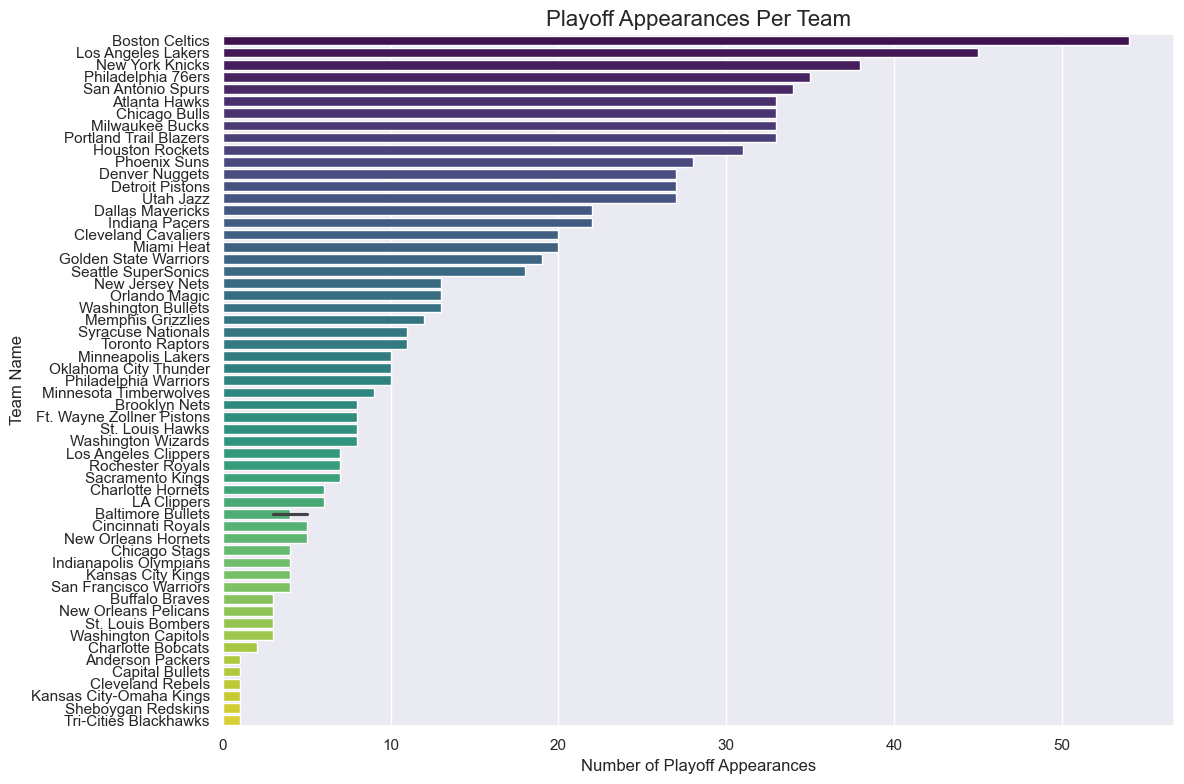

In [49]:
# Calculate the overall average points
total_avg_points = pd.read_sql_query(
    "SELECT AVG(pts_home + pts_away) AS Average_Points FROM game", con
).iloc[0, 0]  # Retrieves the calculated average

# Query teams with below-average points for consecutive seasons
query = f"""
SELECT 
    team_name_home AS Team_Name,
    team_id_home AS Team_ID,
    COUNT(season_id) AS Seasons_In_Playoff
FROM (
    SELECT 
        season_id,
        team_id_home,
        team_name_home
    FROM game WHERE season_type = 'Playoffs'
    GROUP BY season_id, team_id_home
)
GROUP BY team_name_home, team_id_home
ORDER BY Seasons_In_Playoff DESC
"""

# Execute and display results
below_average = pd.read_sql_query(query, con)
print(below_average)



plt.figure(figsize=(12, 8))
sns.barplot(
    data=below_average.sort_values(by="Seasons_In_Playoff", ascending=False), x="Seasons_In_Playoff", y="Team_Name", hue="Team_Name", dodge=False, palette="viridis", legend=False)

# Add labels and title
plt.title("Playoff Appearances Per Team", fontsize=16)
plt.xlabel("Number of Playoff Appearances", fontsize=12)
plt.ylabel("Team Name", fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()



### Rising action: Number of playoff appearances each season by team


### Climax: Teams with the longest streak of making playoffs


### Falling action: Teams that has the longest streak of not making it to playoffs


### Conclusion: The team that consistently makes it to playoffs (average of seasons played and season playoff)

## Question 4 - Which teams have shown the greatest improvement over the past five years?


In [ ]:
import pandas as pd
import sqlite3

con = sqlite3.connect("./data/nba.sqlite")
games = pd.read_sql_query("SELECT * FROM game", con)

games_recent_5yrs = pd.read_sql_query("""
    SELECT * FROM game 
    WHERE season_type NOT IN ('All Star', 'All-Star') 
    AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

games_recent_5yrs['game_year'] = pd.to_datetime(games_recent_5yrs['game_date']).dt.year

score_stats_home = games_recent_5yrs.groupby(['team_id_home','team_name_home', 'game_year'])['pts_home'].agg(['mean', 'std', 'count'])
score_stats_away = games_recent_5yrs.groupby(['team_id_away','team_name_away', 'game_year'])['pts_away'].agg(['mean', 'std', 'count'])

score_stats_home.index.names = ['team_id', 'team_name', 'game_year']
score_stats_away.index.names = ['team_id', 'team_name', 'game_year']


combined_stats = pd.concat([score_stats_home, score_stats_away])
score_stats_all = combined_stats.groupby(['team_id', 'team_name','game_year']).mean()

score_stats_all = score_stats_all.sort_values(by=['team_name', 'game_year'], ascending=[True, True])

score_stats_all['Difference'] = score_stats_all.groupby('team_name')['mean'].diff()


# teams with highest average
print("Teams highest year over year improvement over past 5 years: ")
print(score_stats_all.sort_values(by='Difference', ascending=False).head(10)) 

season_avg = pd.concat([games_recent_5yrs['pts_home'], games_recent_5yrs['pts_away']]).mean()


score_stats_all_reset = score_stats_all.reset_index()

top_teams = score_stats_all_reset.groupby("team_name")["Difference"].max().nlargest(10).index
top_teams_data = score_stats_all_reset[score_stats_all_reset["team_name"].isin(top_teams)]

plt.figure(figsize=(14, 8))
sns.lineplot(data=top_teams_data,x="game_year", y="mean", hue="team_name", marker="o",palette="tab10")

# Add titles and labels
plt.title("Year-over-Year Team Performance (2019-2023)", fontsize=16)
plt.xlabel("Game Year", fontsize=12)
plt.ylabel("Average Points per Game", fontsize=12)
plt.legend(title="Team Name", fontsize=10, loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()




### Introduction: Average win percentage by season league total (for now)


### Rising action: average win percentage of team by season 


### Climax: Greatest positive change of win percentage per season by team


### Falling action: Greatest negative change of win percentage per season by team


### Conclusion: Average win percentage change over past 5 years per team 

## Question 5 - Which teams have demonstrated the best defensive metrics (e.g., blocks and steals), and how has this impacted their winning consistency?


Teams with the best defensive metrics and their win consistency:
             team_name  avg_blocks  avg_steals     avg_pts  defense_rating
16     Milwaukee Bucks    4.957865    7.359551  117.884831      116.599615
22  Philadelphia 76ers    5.336158    8.050847  112.870056      115.677022
7       Denver Nuggets    4.296919    7.627451  113.400560      116.524058
1       Boston Celtics    5.485876    7.502825  113.909605      116.288191
28           Utah Jazz    5.056657    6.603399  114.716714      116.798305
12         LA Clippers    4.564972    7.211864  113.166667      115.181762
23        Phoenix Suns    4.628895    7.824363  113.702550      115.370022
15          Miami Heat    3.823034    7.676966  109.252809      113.377720
27     Toronto Raptors    5.036932    8.914773  112.068182      114.303464
2        Brooklyn Nets    5.235795    6.821023  114.028409      114.775624
All Defensive Metrics
             team_name  avg_blocks  avg_steals  avg_rebound  avg_fieldgoal  \
16     Mil

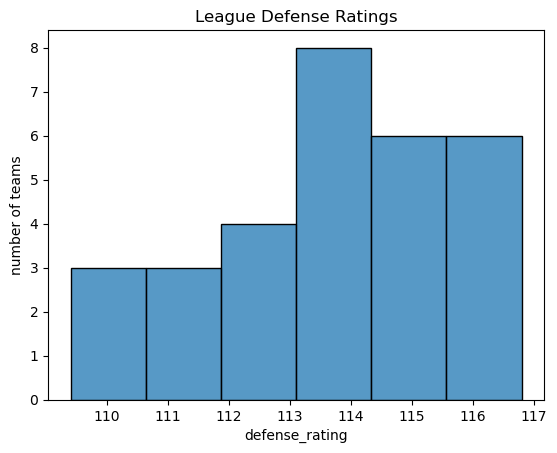

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3

con = sqlite3.connect("data/nba.sqlite")
games_recent_5yrs = pd.read_sql_query("""
	SELECT * FROM game 
	WHERE season_type NOT IN ('All Star', 'All-Star') 
	AND game_date BETWEEN '2019-01-01 00:00:00' AND '2023-12-31 23:59:59'
    ORDER BY game_date DESC
""", con)

regular_games = games_recent_5yrs[games_recent_5yrs['season_type']=='Regular Season']

# home games stats 
home_defense = regular_games[['team_name_home', 'blk_home', 'stl_home', 'wl_home', 'oreb_home', 'fga_home', 'tov_home', 'fta_home', 'pts_home']].rename(
   columns={'team_name_home': 'team_name', 
           'blk_home': 'blocks',
           'stl_home': 'steals',
           'wl_home': 'win_loss',
           'oreb_home': 'off_rebounds',
           'fga_home': 'attempt_fg',
           'tov_home': 'turnovers',
           'fta_home': 'attempt_freethrow',
           'pts_home': 'total_points'})

# away games stats 
away_defense = regular_games[['team_name_away', 'blk_away', 'stl_away', 'wl_away', 'oreb_away', 'fga_away', 'tov_away', 'fta_away', 'pts_away']].rename(
   columns={'team_name_away': 'team_name',
           'blk_away': 'blocks', 
           'stl_away': 'steals',
           'wl_away': 'win_loss',
           'oreb_away': 'off_rebounds',
           'fga_away': 'attempt_fg',
           'tov_away': 'turnovers',
           'fta_away': 'attempt_freethrow',
           'pts_away': 'total_points'})

# defense metrics 
all_defense = pd.concat([home_defense, away_defense])
defense_stats = all_defense.groupby('team_name').agg(
    avg_blocks=('blocks', 'mean'),
    avg_steals=('steals', 'mean'),
    avg_rebound=('off_rebounds', 'mean'),
    avg_fieldgoal=('attempt_fg', 'mean'),
    avg_turnover=('turnovers', 'mean'),
    avg_freethrow=('attempt_freethrow', 'mean'),
    avg_pts=('total_points', 'mean'),
).reset_index()

# win rate 
wins = all_defense[all_defense['win_loss'] == 'W'].groupby('team_name').size()
total_games = all_defense.groupby('team_name').size()
win_rates = (wins / total_games).reset_index(name='win_rate')

# defense rating 
defense_analysis = pd.merge(defense_stats, win_rates, on='team_name')
defense_analysis['defense_rating'] = (defense_analysis['avg_pts'] / (.96 * defense_analysis['avg_fieldgoal'] + defense_analysis['avg_turnover'] + .44 * defense_analysis['avg_freethrow'] - defense_analysis['avg_rebound']))*100
defense_sorted = defense_analysis.sort_values(
   by=['win_rate', 'defense_rating'], 
   ascending=[False, True] #a lower defense rating is better than a higher one apparently
)

print("Teams with the best defensive metrics and their win consistency:")
print(defense_sorted[['team_name', 'avg_blocks', 'avg_steals', 'avg_pts', 'defense_rating']].head(10)) #Q, this only has the four metrics, we can ask the group if they want to use them all but we mostly talk about blocks, steals, and defense rating in the storyboard
print("All Defensive Metrics")
print(defense_sorted.head(10)) #Left all columns here if we decide to use it

ax = sns.histplot(data= defense_sorted[['defense_rating']], x="defense_rating")
ax.set_ylabel("number of teams")
ax.set_title("League Defense Ratings")
plt.show()



### Introduction:  Average blocks and steals per game by season

### rising action: average blocks and steals per game by team 

### Climax:  Teams with best blocks and steals (show win percentage)

### Falling action: Worst teams when it comes to blocks and steals (show win percentage)

### Conclusion: Teams with highest win percentage has these blocks and steals 